In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
import pandas as pd
from pandas import DataFrame, Series
from __future__ import division
import seaborn as sns
import math
from sklearn.metrics import r2_score
from sklearn.cross_validation import train_test_split
sns.set(style='ticks', palette='Set2')
%matplotlib inline

# This is the notebook we saw in Lecture 5. There are a few things we have not discussed in lecture, specifically, R^2. You can read up on this, or skip it... the main point for now is the idea of visualizing and then adding an interaction term. 

# The dataset for this example is from the website for the book by Gelman and Hill, on Multilevel Regression. You can download it from there. 

In [24]:
kidiq = pd.read_stata('ARM_Data/child.iq/kidiq.dta')

# Modeling the relationship between the data

We have output typically denoted by: $Y_i$, $i=1,...,n$, and we denote the the input by $X_{ij}$, $i=1,...,n$, $j=1,...,p$. $X_{ij}$ is the $i^{th}$ observation of the $j^{th}$ covariate. 

We encode all $n$ values of $Y_i$ in the vector $Y$, and all values of $X_{ij}$ in the matrix $X$.
 

Jargon:
    
    Y: response variables, target variables, dependent variables, outcomes.
    X: features, covariates, explanatory variables, independent variables, design matrix.

What should we do? How are X and Y related? How should we search for relationships?

In [25]:
kidiq.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1.0,121.117529,4,27
1,98,1.0,89.361882,4,25
2,85,1.0,115.443165,4,27
3,83,1.0,99.449639,3,25
4,115,1.0,92.745710,4,27


What is the "Y" and what is the "X"?

Some notes:

    Some variables are continuous (or close): kid_score, mom_iq, mom_age
    Other variables are categorical: mom_hs, mom_work

Goal: how are X and Y related?
$$
Y_i \approx f(X_i)
$$
(What are the relevant dimensions?)

What is such a model good for?

Models: 

    * Prediction
    * Correlations/Relationships
    * Causality(?)
    

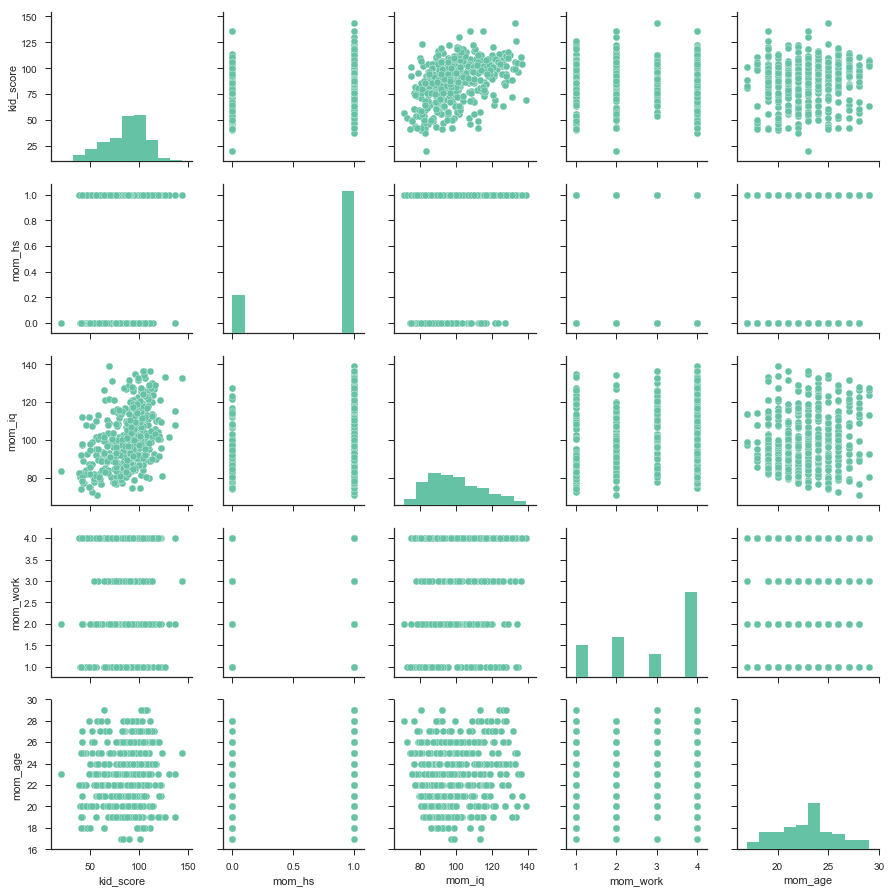

In [26]:
sns.pairplot(kidiq)
sns.despine()

It seems that kid_score and mom_iq may have some correlation. Let's see these together:

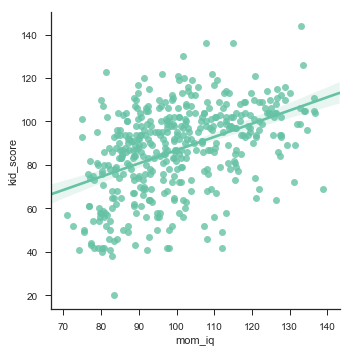

In [27]:
sns.lmplot("mom_iq","kid_score",kidiq)
sns.despine()

We can also use other (even categorical) variables. For example, let's use mom_hs and kid_score.

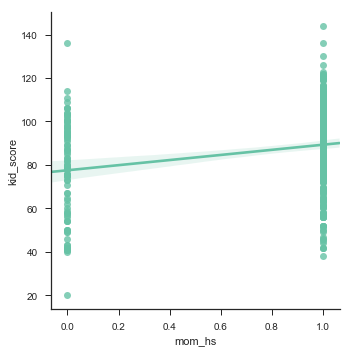

In [28]:
sns.lmplot("mom_hs","kid_score",kidiq)
sns.despine()

Some Pandas/Python practice: we extract the numpy arrays from the dataframe, and use linear_model from scikit-learn to perform the same fit.

In [29]:
kidiq_X = kidiq.as_matrix(["mom_iq"])
kidiq_Y = kidiq.as_matrix(["kid_score"])
lr = linear_model.LinearRegression()
lr.fit(kidiq_X,kidiq_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [30]:
# These are the coefficients we found.
print (lr.coef_, lr.intercept_)

[[0.60997457]] [25.79977785]


What is the interpretation of these numbers? When we plot this, 25.8 is the intercept, and 0.61 is the slope. What does that mean?

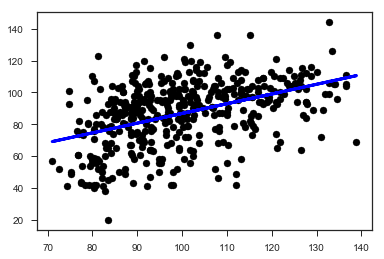

In [31]:
# And we can plot the fit again:
plt.scatter(kidiq_X, kidiq_Y,  color='black')
plt.plot(kidiq_X, lr.predict(kidiq_X), color='blue',
         linewidth=3)

In [32]:
# Let's repeat, but now solving a multiple regression, with control variables 
# (or independent variables) mom_iq and also the categorical variable mom_hs
kidiq_X = kidiq.as_matrix(["mom_iq","mom_hs"])
kidiq_Y = kidiq.as_matrix(["kid_score"])
lr = linear_model.LinearRegression()
lr.fit(kidiq_X,kidiq_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [33]:
# These are the coefficients we found.
print (lr.coef_, lr.intercept_)

[[0.56390605 5.95011691]] [25.73153818]


Note that the coefficient multiplying "mom_iq" has changed -- it is now just 0.56. What does that mean about the new covariates? What does it mean about our original conclusion and the assumptions behind that?



We can compute this same solution manually, using the formula:
$$
\hat{\beta} = (X^{\top}X)^{-1}X^{\top}y
$$
We have to make sure that we allow for the constant term by appending a column of all ones to X. Then we can apply the above formula.

In [34]:
X = np.column_stack((kidiq_X,np.ones(kidiq_Y.shape[0])))
np.dot(np.dot(np.linalg.inv(np.dot(X.transpose(),X)),X.transpose()),kidiq_Y)

array([[ 0.56390605],
       [ 5.95011691],
       [25.73153818]])

Writing this explicit formula for $\hat{\beta}$ helps us start answering the question: How much do we trust these coefficients? We can compute what is called the standard error of the coefficients of $\hat{\beta}$. And writing it explicitly as above, helps with this.

Supose the "truth" (let us imagine/pretend for a moment that the model is the truth...) is
$$
y = X \beta + w,
$$
where $w \sim N(0,\sigma^2)$. Then plugging this in to our formulat for $\hat{\beta}$ above, we have:

$$
\hat{\beta}=(X^{\top}X)^{-1}X^{\top}y = (X^{\top}X)^{-1}X^{\top}(X \beta + w) = \beta + (X^{\top}X)^{-1}X^{\top}w.
$$

For one thing, this tells us that $\hat{\beta}$ is unbiased. 

Beyond this, it tells us what its distribution is. This is somewhat of a subtle point. What do we mean that $\hat{\beta}$ has a distribution, when it is just a deterministic function of the data??

Before we see the data, we can think of $y$ as being random, because it is a function of $\beta$, but also of the additive noise. Therefore, before we see $X$ and $y$, then $\hat{\beta}$ is also random. It is important to think of it this way. It's like saying: "if we collect more data from a "statistically identical" population, what kind of variation would we expect to see in our solution, $\hat{\beta}$? This is another way to get to the answer of "how much do we trust our solution?"

Thus, since we know that

$$
\hat{\beta} = \beta + (X^{\top}X)^{-1}X^{\top}w,
$$

we can compute the variance, and hence the standard deviation, of $\hat{\beta}_1,\dots,\hat{\beta}_n$. This quantity is called the standard error. Anything within about 2 standard deviations would be "reasonable" or "plausible". Note that different coefficients of $\hat{\beta}$ can have different standard errors.

Let us compute this for the example above.

In [35]:
V = np.linalg.inv(np.dot(X.transpose(),X))
sigma = np.sqrt(sum((kidiq_Y-np.mean(kidiq_Y))**2)/(kidiq_Y.shape[0]-1))
std_error = np.sqrt(np.diagonal(V))*sigma
# The standard errors:
print ("The standard errors are", std_error)
print ("Hence all our computed values are significant, in that they do not change sign within two standard deviations.")

The standard errors are [0.06817274 2.48927078 6.61221769]
Hence all our computed values are significant, in that they do not change sign within two standard deviations.


# Residuals and $R^2$-Values

Recall our discussion about how much statistical noise, or fluctuations, we should expect. This relates to the quality of the fit. What can we say about the errors of our estimate?

To begin answering this question, we have to consider the vector of residuals. 

Let $\hat{Y}$ be the predicted values given by $\hat{\beta}$, that is, $\hat{Y} = X \hat{\beta}$. Then the residuals are given by the difference between the true output ($Y$) and the fitted (or predicted) output ($\hat{Y}$):
$$
\hat{r} = Y - \hat{Y} = Y - X \hat{\beta}
$$
# Exercise: show that the residuals sum to zero.

In other words: 
$$
\bar{Y} = \frac{1}{n} \sum Y_i = \frac{1}{n} \sum \hat{Y}_i = \hat{\bar{Y}}
$$

The R-Value is a measure of goodness of fit. It tries to capture how much of the variation in $Y$ is explained by $\hat{Y}$.
# Show that $$ \|Y\|^2 - n \bar{Y}^2 = \|\hat{r}\|^2 + \|\hat{Y}\|^2 - n \hat{\bar{Y}}^2.$$

The point of this exercise is that it suggests that a measure of the goodness of fit, is the variance of $\hat{Y}$ compared to the variance of $Y$.

This is the definition of the $R^2$ criterion:
$$
R^2 = \frac{\sum (\hat{Y}_i - \hat{\bar{Y}})^2}{\sum (Y_i - \bar{Y})^2}.
$$
Note that $R^2 \leq 1$. Bigger is interpreted as better. $R^2=1$ means that $\hat{Y}$ "explains" all the variance in $Y$.

In [36]:
# Let's compute R^2 when we fit to just mom_iq
# Let's repeat, but now solving a multiple regression, with control variables 
# (or independent variables) mom_iq and also the categorical variable mom_hs
kidiq_X = kidiq.as_matrix(["mom_iq"])
kidiq_Y = kidiq.as_matrix(["kid_score"])
lr = linear_model.LinearRegression()
lr.fit(kidiq_X,kidiq_Y)
lr.score(kidiq_X,kidiq_Y)

0.20095123075855104

In [37]:
# and when we fit to mom_iq and to mom_hs
kidiq_X = kidiq.as_matrix(["mom_iq","mom_hs"])
kidiq_Y = kidiq.as_matrix(["kid_score"])
lr = linear_model.LinearRegression()
lr.fit(kidiq_X,kidiq_Y)
lr.score(kidiq_X,kidiq_Y)

0.21414651708983581

In [38]:
# And now let's try fitting to everything
kidiq_X = kidiq.as_matrix(["mom_iq","mom_hs","mom_work","mom_age"])
kidiq_Y = kidiq.as_matrix(["kid_score"])
lr = linear_model.LinearRegression()
lr.fit(kidiq_X,kidiq_Y)
lr.score(kidiq_X,kidiq_Y)

0.21504503560100807

Again the R^2 value is not a final test. It is merely another interpretation of the goodness of fit, that can help provide some guidance.

In [39]:
# Back to fitting mom_iq and mom_hs. Is this a good idea? What does the regression mean?
# and when we fit to mom_iq and to mom_hs
kidiq_X = kidiq.as_matrix(["mom_iq","mom_hs"])
kidiq_Y = kidiq.as_matrix(["kid_score"])
lr = linear_model.LinearRegression()
lr.fit(kidiq_X,kidiq_Y)
print (lr.coef_, lr.intercept_)

[[0.56390605 5.95011691]] [25.73153818]


This means that we are fitting a model of the form: 

$${\rm kid.score} = 25.7 + 0.56 * {\rm mom\_iq} + 6 * {\rm mom\_hs}$$

Note that this means: the coefficient of mom_iq is (forced to be) the same within each group. That is, this model says (by design) that the association of mom_iq on kid_score is the same, regardless of mom_hs.

Do the data support this?

We can plot the resulting lines for each subgroup: mom_hs = 0 and mom_hs = 1. That is, we can plot the conditional regression inside each subgroup. 

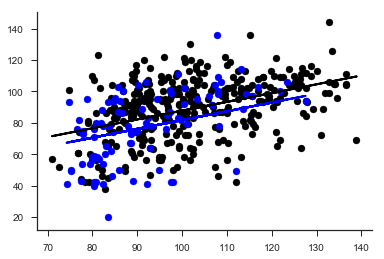

In [40]:
kidiq_hs = kidiq[kidiq.mom_hs==1]
kidiq_nohs = kidiq[kidiq.mom_hs==0]
X_hs = kidiq_hs.as_matrix(["mom_iq"])
Y_hs = kidiq_hs.as_matrix(["kid_score"])
X_nohs = kidiq_nohs.as_matrix(["mom_iq"])
Y_nohs = kidiq_nohs.as_matrix(["kid_score"])
# And we can plot the fit again:
plt.scatter(X_hs, Y_hs,  color='black')
plt.scatter(X_nohs, Y_nohs,  color='blue')
plt.plot(X_hs, 25.7+0.56*X_hs + 6, color='black',
         linewidth=2)
plt.plot(X_nohs, 25.7+0.56*X_nohs, color='blue',
         linewidth=2)
sns.despine()

# Exercise: Include an interaction term
Specifically: load the kidiq data set into a data frame, figure out how to add an interaction term, and then solve the resulting linear regression now with three features (three covariates), namely, mom_iq, mom_hs, and mom_hs * mom_iq